<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/04-exotic-fruit-classifier/fruits_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TropicTaste Exotic Fruit Classification — KNN Model  

    👨‍💻 Developed as part of the AI Engineering Master – Week 3


This notebook demonstrates how to build and evaluate a **K-Nearest Neighbors (KNN)** classifier to predict the type of exotic fruit based on numeric physical characteristics. The goal is to automate and improve the accuracy of the fruit classification process currently done manually.

---

## Project Highlights

The project covers the full machine learning workflow:

- Load and preprocess a dataset of exotic fruits with numeric features.
- Handle missing values, encode categorical targets, and scale features.
- Perform exploratory data analysis (EDA) with visualizations.
- Train a baseline KNN classifier.
- Optimize hyperparameters (`k`, distance metric, weights) using `GridSearchCV`.
- Evaluate model performance with cross-validation, accuracy metrics, and confusion matrix.
- Visualize results including accuracy trends and PCA projections.

---

## Key Goals

- Automate fruit classification to improve operational efficiency.
- Reduce human errors in the sorting process.
- Optimize model accuracy with proper tuning and validation.
- Provide clear visual interpretation of results and model behavior.

---

## Notebook Contents

1. Data loading and inspection  
2. Exploratory Data Analysis (EDA)  
3. Preprocessing
4. Baseline KNN training  
5. Hyperparameter tuning with GridSearchCV  
6. Model evaluation and visualization  
7. Conclusions and next steps

---

🔗 GitHub Repository: [tropictaste-fruit-classification](<repo-url>)


In [ ]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning tools
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Statistical tools
from statsmodels.stats.outliers_influence import variance_inflation_factor

# **Utilities functions**

### This section contains general-purpose helper functions to support exploratory data analysis, statistical diagnostics, and feature evaluation in machine learning workflows.


In [ ]:
def plot_distribution(df, target_col='Frutto'):
    """
    Plots the distribution of numerical features in the dataframe, excluding the target column.
    Creates a 2x3 grid of histograms with KDE for each feature.

    Parameters:
    df : pandas.DataFrame
        The input dataframe containing numerical features.
    target_col : str, optional (default='Frutto')
        The column to exclude from plotting (usually the target variable).
    """
    feature_cols = df.select_dtypes(include='number').columns.tolist()
    if target_col in feature_cols:
        feature_cols.remove(target_col)

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, col in enumerate(feature_cols):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")

    # Removing any empty axes if feature_cols < 6
    for j in range(len(feature_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
def show_correlation_matrix(selected_df: pd.DataFrame) -> None:
    """
    Displays a heatmap for pairwise correlation between numerical features.
    Helps to detect linear dependencies.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(selected_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

In [ ]:
def calculate_vif(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates Variance Inflation Factor (VIF) to assess multicollinearity.
    VIF > 5 or 10 indicates strong correlation between features.
    Returns a DataFrame sorted descending by VIF.
    """
    vif = pd.DataFrame()
    vif['feature'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif.sort_values(by='VIF', ascending=False)

# Data loading and inspection


In [ ]:
# Load dataset into pandas dataframe
dataset_url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv'
fruits_df = pd.read_csv(dataset_url)

In [ ]:
# Show first few rows to get an initial view of data structure and sample values
fruits_df.head()

,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,Mela,86.40,89.68,8.69,9.61,2.41
1,Mela,77.58,73.45,6.49,7.20,3.87
2,Mela,81.95,81.66,6.40,9.09,2.88
3,Mela,66.33,36.71,6.78,8.21,2.55
4,Mela,56.73,75.69,5.78,9.15,3.88


In [ ]:
# Check data types and presence of nulls
fruits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Frutto                 500 non-null    object 
 1   Peso (g)               500 non-null    float64
 2   Diametro medio (mm)    500 non-null    float64
 3   Lunghezza media (mm)   500 non-null    float64
 4   Durezza buccia (1-10)  500 non-null    float64
 5   Dolcezza (1-10)        500 non-null    float64
dtypes: float64(5), object(1)
memory usage: 23.6+ KB


✅ There are 500 rows and 6 columns. The data types are float64 and object (which is the target).

In [ ]:
# Confirm there are no missing values in any column
fruits_df.isna().sum()

,0
Frutto,0
Peso (g),0
Diametro medio (mm),0
Lunghezza media (mm),0
Durezza buccia (1-10),0
Dolcezza (1-10),0


✅ There are no null values.

In [ ]:
# Check unique fruit classes in the target column to verify labels
fruits_df['Frutto'].unique()

array(['Mela', 'Banana', 'Arancia', 'Uva', 'Kiwi'], dtype=object)

✅ The values in the 'Frutto' column all seem correct (without duplicates like 'Mela' or 'mela').

# Exploratory Data Analysis (EDA)

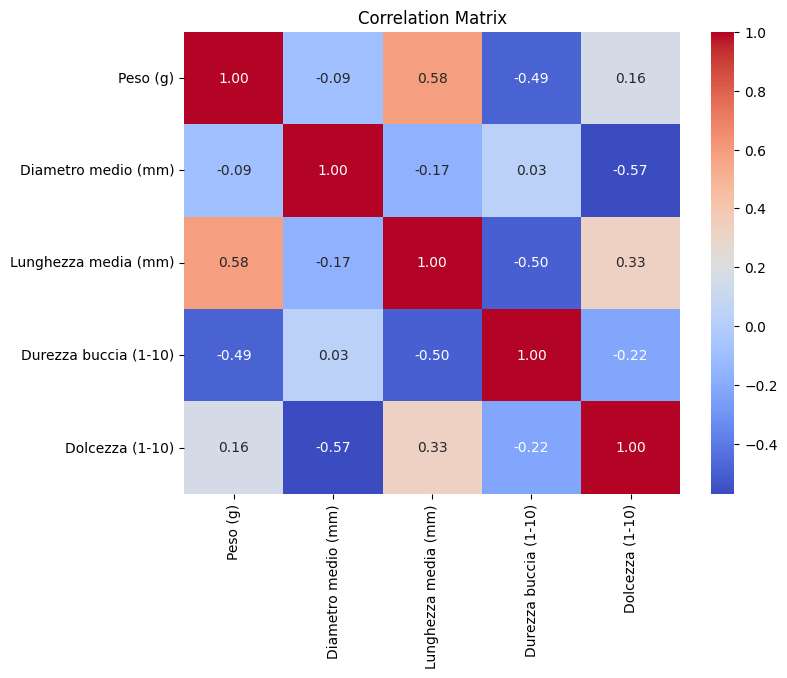

In [ ]:
# Correlation matrix to understand relationships between numeric features
show_correlation_matrix(fruits_df.drop(columns=['Frutto']))

📈 Correlation Analysis
The correlation matrix shows the pairwise relationships between the numerical features in the dataset:

- Weight (Peso, g) and Average Length (Lunghezza media, mm) have a moderate positive correlation (~0.58), suggesting that heavier fruits tend to be longer.

- Weight and Peel Hardness (Durezza buccia, 1–10) are moderately negatively correlated (~ -0.49), indicating that heavier fruits generally have slightly softer skins.

- Weight and Average Diameter (Diametro medio, mm), as well as Weight and Sweetness (Dolcezza, 1–10) show weak correlations close to zero, implying that weight is not strongly linearly related to these features.

- Average Diameter and Sweetness have a moderate negative correlation (~ -0.57), suggesting that fruits with larger diameters tend to be slightly less sweet.

- Average Length and Peel Hardness are moderately negatively correlated (~ -0.50), meaning that longer fruits tend to have softer skins.

The remaining correlations between features are relatively weak or near zero, indicating limited linear relationships.

Insight: Understanding these correlations is useful for feature selection and engineering. Strongly correlated features may provide redundant information or highlight relationships that can influence the classification of fruits.

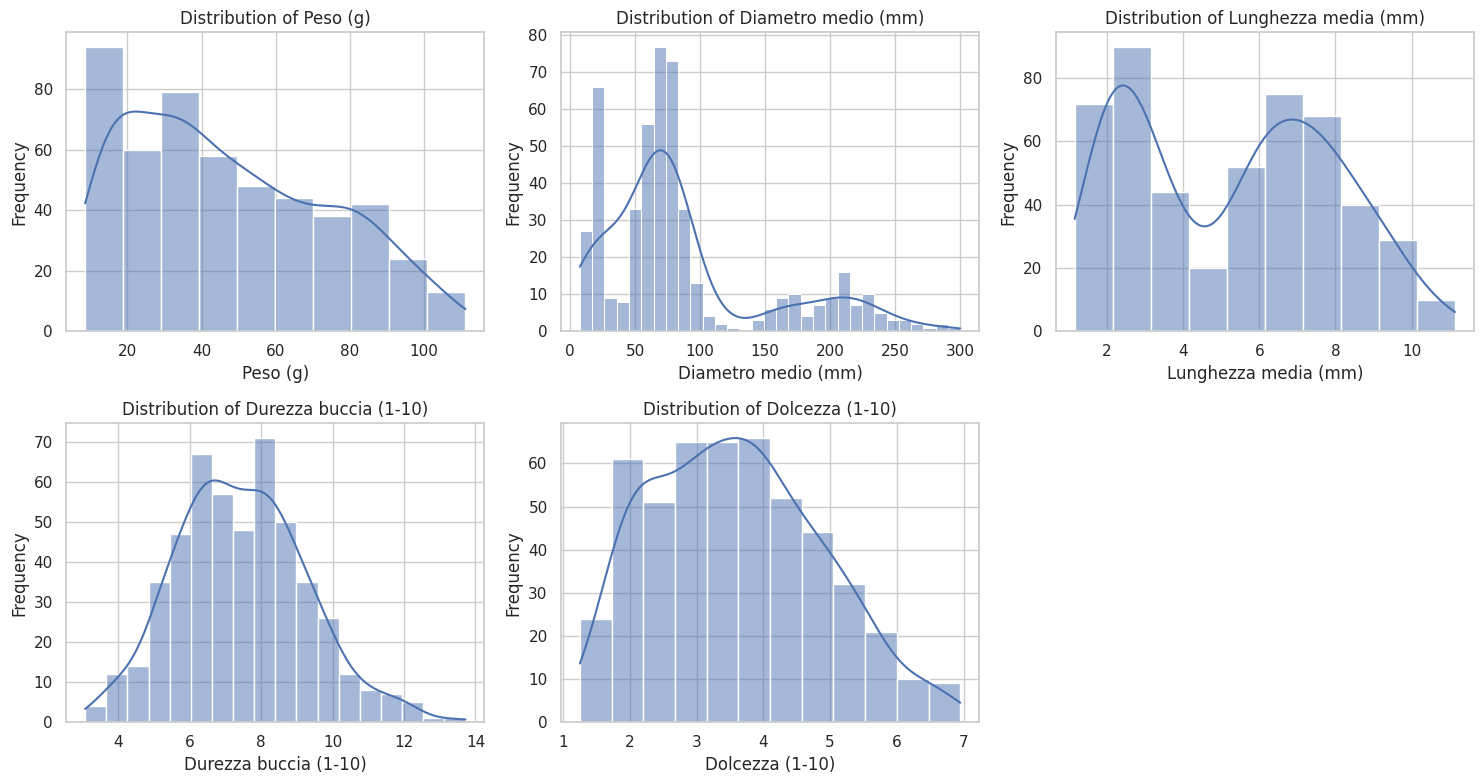

In [ ]:
# Visualize the distributions of numerical features to spot skewness or multimodality
plot_distribution(fruits_df)

### Observations on Feature Distributions

- **Weight (g):**  
  The distribution is right-skewed with a long tail towards higher values. This indicates that most fruits have lower weights but there are some heavier outliers. Such asymmetry suggests considering a transformation (e.g., logarithmic or square root) to stabilize variance and make the data more normally distributed.

- **Average Diameter (mm):**  
  The distribution is multimodal, showing two distinct peaks: one cluster around smaller diameters and another around larger diameters. This might reflect the presence of different fruit types or size groups in the dataset. The distribution is not symmetric, so transformations or clustering-aware methods could be useful.

- **Average Length (mm):**  
  Also multimodal, suggesting size heterogeneity among fruits..

- **Peel Hardness (1-10):**  
  This is the only feature showing an approximately bell-shaped (normal) distribution. Given its symmetry, no transformation is likely needed for this variable.

- **Sweetness (1-10):**
  Moderately right-skewed; contains useful discriminatory information for classification.

### Implications for KNN

Skewed (Weight, Sweetness) and multimodal (Diameter, Length) features may benefit from transformations to reduce skewness and stabilize variance, improving distance-based calculations in KNN and potentially enhancing classification accuracy.

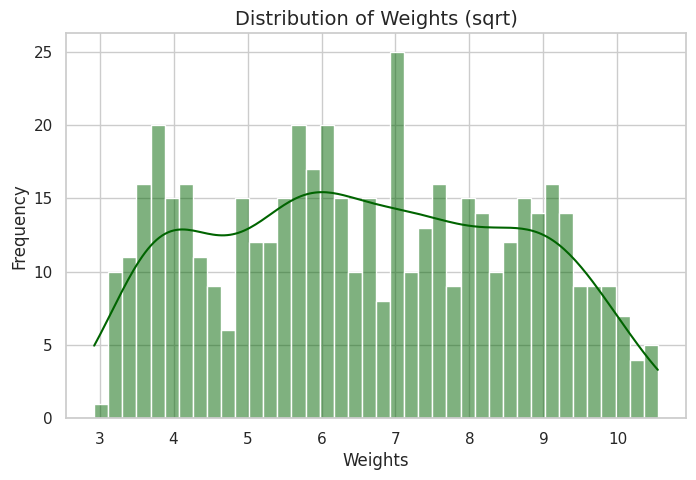

In [ ]:
# Compare sqrt and log transformations for skewed Weight feature
plt.figure(figsize=(8,5))
sns.histplot(np.sqrt(fruits_df['Peso (g)']), bins=40, kde=True, color='darkgreen')
plt.title('Distribution of Weights (sqrt)', fontsize=14)
plt.xlabel('Weights')
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

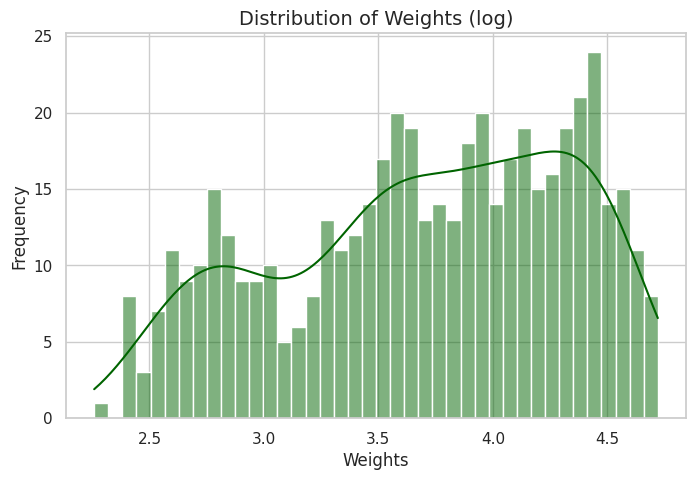

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(np.log(fruits_df['Peso (g)'] + 1), bins=40, kde=True, color='darkgreen')
plt.title('Distribution of Weights (log)', fontsize=14)
plt.xlabel('Weights')
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

**📊Feature Transformation: Weight (g)**

The original weight distribution is right-skewed. Two common transformations were tested: square root (sqrt) and logarithm (log).

- Square root: Makes the histogram more symmetric and visually closer to normal.
- Logarithm: Reduces the impact of extreme high values and compresses the scale more aggressively.

**Modeling insight:**

Despite sqrt appearing more "normal," models trained with log-transformed weights consistently generalized better on the validation set. Sqrt tended to overfit, capturing noise in the training data.

**‼️Key notes:**

Visual normality does not guarantee better modeling. Log transformation often handles outliers and stabilizes variance more effectively, improving model robustness and predictive performance.

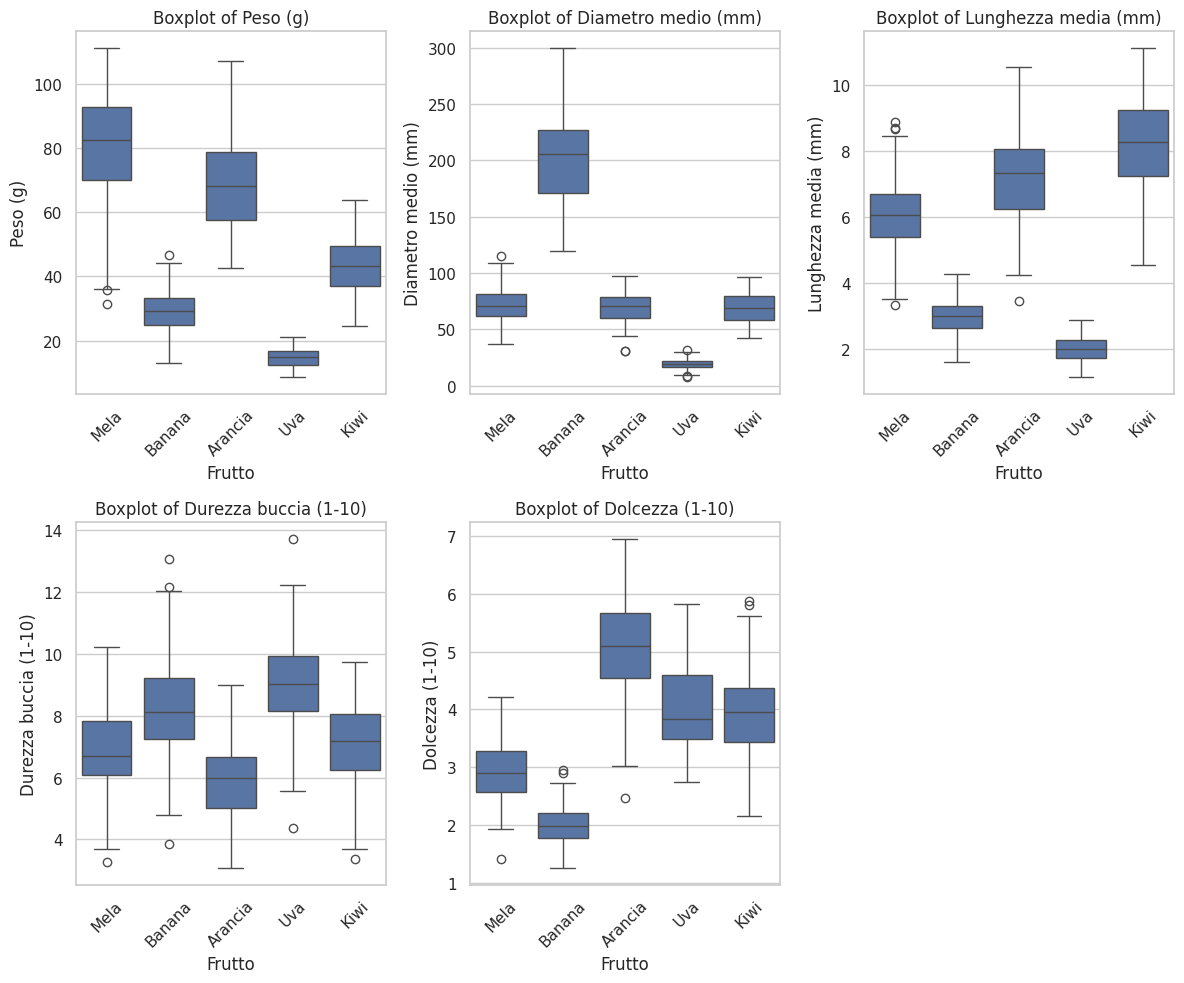

In [ ]:
# Boxplots showing distributions of features vs fruit classes to see class separability visually
numerical_cols = ['Peso (g)', 'Diametro medio (mm)', 'Lunghezza media (mm)', 'Durezza buccia (1-10)', 'Dolcezza (1-10)']
target_col = fruits_df['Frutto']

plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=target_col, y=col, data=fruits_df)
    plt.title(f'Boxplot of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 📈Overview of the Boxplots

- Good class separability. Weight, diameter, and length show strong between-class shifts (especially for grapes, bananas, and kiwis), which should benefit a distance-based model like KNN—provided features are scaled.

- Scale & skew matter. Because size features differ in scale and skew, normalization (e.g., MinMax) and mild transformations (e.g., log1p/sqrt for weight) stabilize distances and typically improve KNN performance.

- Combine signals. No single feature perfectly separates all fruits, but the combination of size (weight/diameter/length) plus sweetness and peel hardness delivers a robust multi-dimensional signature for each fruit type.

- A few outliers appear; I'll consider robust scaling or to verify data quality if they unduly influence neighborhood distances.

In [ ]:
# Encode target labels as integers for ML algorithms
label_encoder = LabelEncoder()
fruits_df['Frutto'] = label_encoder.fit_transform(fruits_df['Frutto'])

In [ ]:
# Clip sweetness and hardness values to max 10 if needed
cols_to_cap = ['Dolcezza (1-10)', 'Durezza buccia (1-10)']
fruits_df[cols_to_cap] = fruits_df[cols_to_cap].clip(upper=10)

In [ ]:
# Define features and target for modeling
X = fruits_df.drop('Frutto', axis=1)
y = fruits_df['Frutto']

In [ ]:
# Split into train and test sets (15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=45)

# Preprocessing and Pipeline

Building a pipeline to consolidate preprocessing and model training for clean and reproducible workflows.

In [ ]:
# Define columns requiring specific transformations
cols_to_scale = ['Diametro medio (mm)', 'Lunghezza media (mm)', 'Dolcezza (1-10)', 'Durezza buccia (1-10)']
# Weight to be transformed with log first, then scaled
cols_to_log = ['Peso (g)']

# Create a pipeline for log-transforming and scaling weight feature
log_transformer = FunctionTransformer(np.log1p, validate=False)
log_and_scale = Pipeline([
    ('log', log_transformer),
    ('scale', MinMaxScaler())
])

# ColumnTransformer to apply transformations selectively to columns
preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', log_and_scale, ['Peso (g)']),
        ('scale', MinMaxScaler(), cols_to_scale)
    ],
    # Keep other columns as-is
    # remainder='passthrough'
)

# Complete ML pipeline including preprocessing and KNN classifier
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    # Optional PCA step for dimensionality reduction:
    # ('pca', PCA(n_components=0.95)),
    ('knn', KNeighborsClassifier())
])

# Hyperparameter tuning with GridSearchCV

We use StratifiedKFold cross-validation to preserve the class distribution across all folds, ensuring a fair and reliable evaluation in this multi-class classification task. An exhaustive grid search over KNN hyperparameters (n_neighbors, weights, and metric) is then performed to identify the optimal configuration, while mitigating overfitting. Fo example, by avoiding overly small neighbor counts such as k=1.

In [ ]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=45)

param_grid = {
     # k from 2 to 55, avoiding k=1 to reduce overfitting risk
    'knn__n_neighbors': range(2, 56),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=45, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('log_and_scale',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('scale',
                                                                                          MinMaxScaler())]),
                                                                         ['Peso '
                                                                          '(g)']),
                                                                        ('scale',
                                                                         MinMaxScaler(),
                                                                         ['Diametro '
                                                                          'medio '
                                                                          '(mm)',
                                                                          'Lunghezza '
                                                                          'media '
                                                                          '(mm)',
                                                                          'Dolcezza '
                                                                          '(1-10)',
                                                                          'Durezza '
                                                                          'buccia '
                                                                          '(1-10)'])])),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'knn__n_neighbors': range(2, 56),
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy')

# Model evaluation and visualization  


In [ ]:
# Print best parameters found and best CV accuracy
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}\n")

# Predictions on train and test sets using best estimator
y_train_pred = grid_search.predict(X_train)
y_pred = grid_search.predict(X_test)

# Calculate and display train and test accuracy
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Train accuracy: {train_acc:.4f}")

test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}\n")

# Classification errors for train and test sets
train_error = 1 - train_acc
test_error = 1 - test_acc

print(f"Train classification error: {train_error:.4f}")
print(f"Test classification error: {test_error:.4f}\n")

# Detailed classification reports for train and test datasets
print("Train set classification report:")
print(classification_report(y_train, y_train_pred))

print("Test set classification report:")
print(classification_report(y_test, y_pred))

Best params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 55, 'knn__weights': 'uniform'}
Best CV accuracy: 0.9388

Train accuracy: 0.9482
Test accuracy: 0.8667

Train classification error: 0.0518
Test classification error: 0.1333

Train set classification report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        77
           1       1.00      1.00      1.00        90
           2       0.94      0.88      0.91        86
           3       0.91      0.99      0.95        87
           4       1.00      1.00      1.00        85

    accuracy                           0.95       425
   macro avg       0.95      0.95      0.95       425
weighted avg       0.95      0.95      0.95       425

Test set classification report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.78        23
           1       1.00      1.00      1.00        10
           2       0.65      0.93      0.76     

### **KNN Performance & Learning Curve Interpretation**

**Model configuration:**
- Best parameters: `n_neighbors=55`, `metric='manhattan'`, `weights='uniform'`
- Best CV accuracy: 0.9388

**Final evaluation:**
- Train accuracy: 0.9482 (error = 0.0518)
- Test accuracy: 0.8667 (error = 0.1333)
- Slight performance drop from train to test indicates **mild overfitting**, but generalization remains strong.

**Class-level performance:**

- Most classes show perfect or near-perfect scores on the train set.
- On the test set, Classes 1 and 4 maintain perfect precision and recall.
- Class 2 shows precision drop (0.65) but high recall (0.93), indicating some false positives but few missed detections.
- Class 0 has lower recall (0.70), suggesting more missed examples relative to precision.
- Class 3 remains balanced with precision = 0.92 and recall = 0.85.

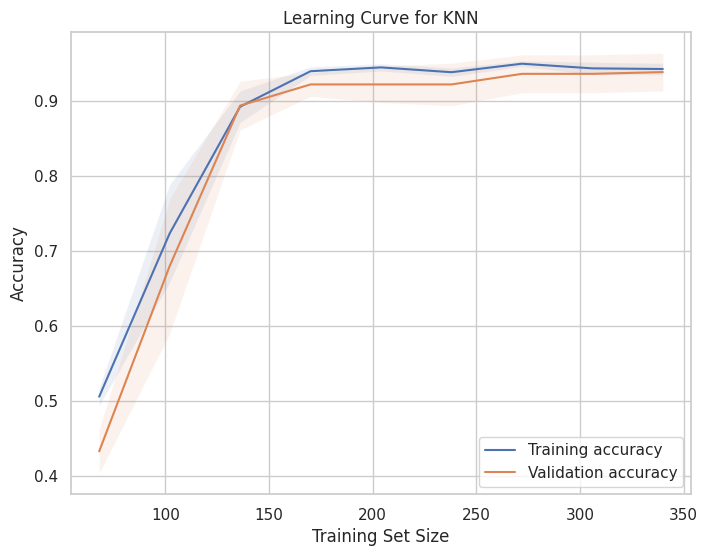

In [ ]:
# Extract best trained pipeline from grid search
best_knn_pipeline = grid_search.best_estimator_

# Generate learning curves to inspect model behavior versus training size
train_sizes, train_scores, val_scores = learning_curve(
    best_knn_pipeline, X_train, y_train,
    cv=cv_strategy,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves for training/validation accuracy
plt.figure(figsize=(8,6))
# Accuracy on the training subset used in each iteration
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
# Average accuracy on the validation folds in the internal cross-validation
plt.plot(train_sizes, val_mean, label='Validation accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

plt.title('Learning Curve for KNN')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### **📈Learning curve overview:**

- Both **training** and **validation** accuracy increase rapidly with training size up to ~150 samples, after which they **plateau around 0.94–0.92.**
- The small, stable gap between curves suggests the model has **low variance and good generalization capacity.**
- Adding more data beyond ~200 samples yields **diminishing returns**, as both curves flatten.
- Early low scores reflect KNN’s strong reliance on sufficient data density; performance improves sharply once the feature space is adequately populated.


**‼️Key notes:**

The tuned KNN model delivers high accuracy and balanced generalization across most fruit classes. Slight weaknesses in Class 0 and Class 2 classification could be addressed by feature scaling optimization, class-specific weighting, or exploring different distance metrics.

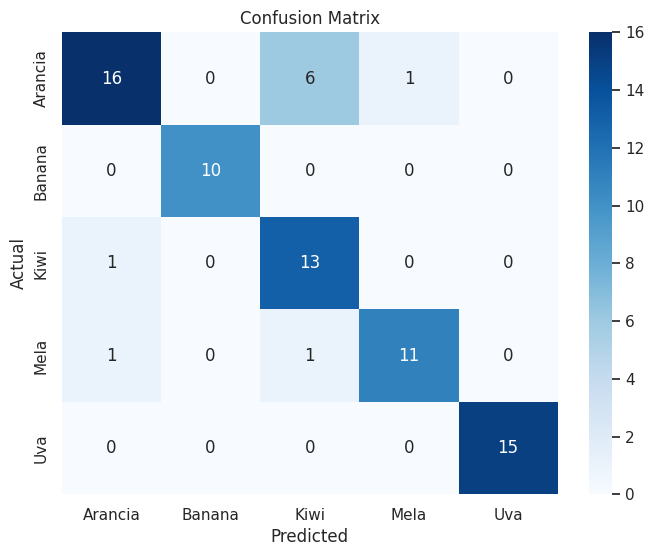

In [ ]:
# Confusion matrix visualization on test data for detailed error analysis
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

-  **Correct Classifications:** The diagonal elements represent frutis correctly classified by the model. For example, all 15 instances of "Uva" and 10 of "Banana" are correctly identified. This indicates that the model is effective at recognizing these types of fruits.

-  **Misclassifications:** Off-diagonal elements show where the model failed to classify a fruit correctly. Notably, "Arancia" is sometimes misclassified as "Kiwi" (6 instances) and "Mela," and "Kiwi" is misclassified as "Arancia" once. These misclassifications highlight which pairs of fruit the model finds difficult to distinguish.

-  **Model Insights:** Most predictions are concentrated along the diagonal, suggesting high overall accuracy. However, the confusion between "Arancia" and "Kiwi" signals that these fruits may share similar feature profiles

**‼️Key notes:**

Confusion matrix demonstrates solid classification performance, especially for "Uva" and "Banana" but also reveals areas for improvement concerning "Arancia" and "Kiwi."

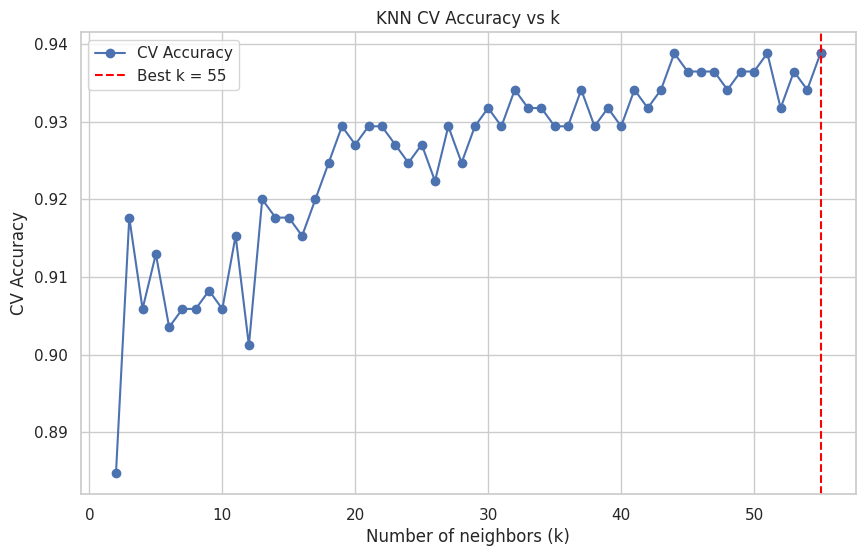

Best k: 55, CV accuracy: 0.9388


In [ ]:
# Extract GridSearchCV results for plotting accuracy vs k neighbors
results = pd.DataFrame(grid_search.cv_results_)

# Convert params to raw data types for plotting
results['param_knn__n_neighbors'] = results['param_knn__n_neighbors'].astype(int)
results['param_knn__weights'] = results['param_knn__weights'].astype(str)
results['param_knn__metric'] = results['param_knn__metric'].astype(str)

best_params = grid_search.best_params_

# Filter results matching best metric and weights settings
mask = (
    (results['param_knn__metric'] == best_params['knn__metric']) &
    (results['param_knn__weights'] == best_params['knn__weights'])
)
filtered_results = results[mask]

if filtered_results.empty:
    print("Warning: No results matched the best params, using all data for plot.")
    filtered_results = results

k_values = filtered_results['param_knn__n_neighbors']
mean_cv_scores = filtered_results['mean_test_score']

best_idx = mean_cv_scores.idxmax()
best_k = k_values.loc[best_idx]
best_score = mean_cv_scores.loc[best_idx]

# Plot CV accuracy vs number of neighbors k
plt.figure(figsize=(10,6))
plt.plot(k_values, mean_cv_scores, marker='o', label='CV Accuracy')
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.scatter(best_k, best_score, color='red')
plt.title('KNN CV Accuracy vs k')
plt.xlabel('Number of neighbors (k)')
plt.ylabel('CV Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best k: {best_k}, CV accuracy: {best_score:.4f}")

### **📈CV Accuracy vs K plot**

The plot above shows how the cross-validated accuracy of the KNN classifier changes as the number of neighbors (K) increases. This visualization is crucial for selecting the optimal value of K and understanding the model's behavior:

- The curve initially rises as k increases, indicating that using a very small number of neighbors may lead to instability and lower accuracy (potentially due to noise or overfitting). As K grows, accuracy improves and stabilizes, reflecting a better generalization capacity by considering more neighbors in the classification decision.

- **Optimal Value of k:** the vertical dashed red line marks the best value of k found via cross-validation (k = 55), where the model achieves its highest validation accuracy (approx. 0.9388, or 93.88%). Choosing this value helps ensure optimal model performance and robustness on unseen data.

  The plot shows that, beyond a certain point, further increasing k results in diminishing returns, with accuracy plateauing or oscillating slightly. This suggests that the model has reached a good balance between bias and variance.

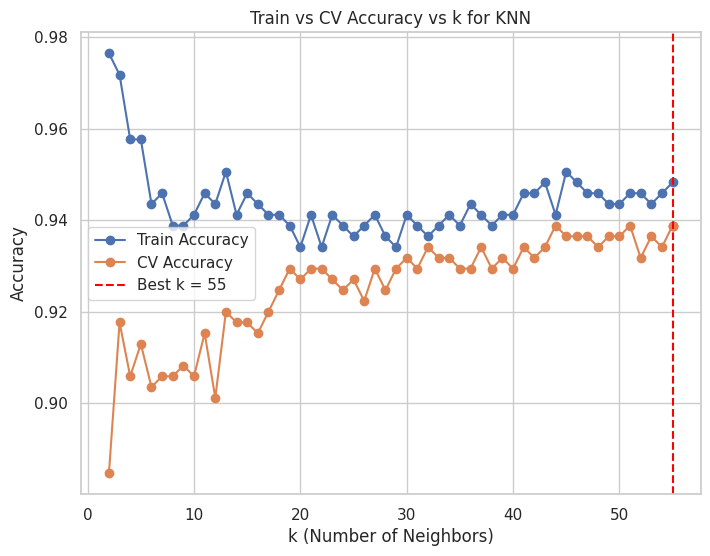

Best k: 55, CV accuracy: 0.9388


In [ ]:
# Additional comparison of Train vs CV accuracy for various k values to detect overfitting
train_scores = []
cv_scores = []

for k in range(2, 56):
    knn_pipeline = pipeline.set_params(knn__n_neighbors=k, knn__weights='uniform', knn__metric='manhattan')
    knn_pipeline.fit(X_train, y_train)
    train_scores.append(knn_pipeline.score(X_train, y_train))
    cv_acc = np.mean(cross_val_score(knn_pipeline, X_train, y_train, cv=cv_strategy, scoring='accuracy'))
    cv_scores.append(cv_acc)

train_scores = np.array(train_scores)
cv_scores = np.array(cv_scores)

best_idx = cv_scores.argmax()
best_k = range(2, 56)[best_idx]
best_cv = cv_scores[best_idx]

plt.figure(figsize=(8,6))
plt.plot(range(2, 56), train_scores, label='Train Accuracy', marker='o')
plt.plot(range(2, 56), cv_scores, label='CV Accuracy', marker='o')
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.scatter(best_k, best_cv, color='red')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('Train vs CV Accuracy vs k for KNN')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best k: {best_k}, CV accuracy: {best_cv:.4f}")

### **Train vs CV Accuracy vs k for KNN Plot**

The plot above compares the training accuracy and cross-validation (CV) accuracy of the KNN classifier as a function of the number of neighbors (k). This visualization helps us understand how the choice of k affects the model's learning and generalization performance:

- **Training Accuracy Trend:**

  The training accuracy starts very high when k is small (close to 1), reflecting that the model perfectly fits the training data by using very few neighbors. However, as k increases, training accuracy gradually decreases and stabilizes around 0.94–0.95. This happens because larger k values smooth the decision boundary, reducing overfitting.

- **Cross-Validation Accuracy Trend:**

  The CV accuracy curve begins lower at very small k values, indicating some overfitting or sensitivity to noise with very few neighbors. As k increases, CV accuracy rises steadily and stabilizes around 0.94, which indicates better generalization on unseen data. At high values of k, we observe converging accuracy values between train and CV datasets.  

- **Optimal k Selection:**

  As said before, the vertical dashed red line marks the best k (k = 55), where CV accuracy reaches its highest value (~0.9388 or 93.88%), balancing the bias-variance trade-off most effectively.

**‼️Key notes:**

For low k, the model has low bias but high variance (overfitting), seen in the large gap between train and CV accuracy. For large k, bias may increase but variance decreases, making the model more robust and less sensitive to noise, as shown by the narrowing gap between train and CV accuracy.

So, selecting k = 55 ensures that KNN model generalizes well to new fruit data, minmizing misclassifications and thus optimizing classification efficiency and accuracy.

# Conclusions